# 대화형 챗봇

## 인코더 디코더 구조 되짚어보기
![image.png](1.png)

입력 문장과 출력 문장 두 가지 병렬 구조로 구성된 데이터셋을 훈련하는 것

**훈련 데이터셋의 구성**

- 입력 : 저는 학생입니다 , 출력 : I am a student

이러한 구조가 인코더 - 디코더 구조로 학습된다면 , 챗봇에서도 동일하게 가능

- 입력 : 오늘 날씨는 어때? , 출력 : 오늘은 화창한 날씨야

## 트랜스포머의 인코더와 디코더

마찬가지로 인코더 디코더 구성을 가지고 있다.

![image.png](2.png)

중간 트랜스포머 내부구조: 

![image-2.png](3.png)

인코더와 디코더의 층을 각각 쌓아 정보를 추출하고 , 단어를 만들어가는 구조

![image-3.png](5.png)

내부의 자세한 구조 - 하나하나 짚어 보자

## import

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

![image-3.png](6.png)

자연어 처리 모델들은 텍스트 문장을 input 으로 주기 위해 임베딩 벡터로 변환하는 벡터화

과정을 거친다. 트랜스포머는 추가로 임베딩 벡터에 어떤 값을 더해준 뒤에 입력으로 사용

위 그림에서 `positional Encoding`에 해당

![image-3.png](7.png)

이렇게 하는 이유 : 트랜스포머 모델은 단어를 순차적이 아닌 한꺼번에 입력받기 때문에

단어의 순서를 모름, 따라서 위치정보를 알려줘야 한다.

![image-3.png](8.png)

임베딩 벡터와 포지셔널 인코딩의 덧셈은 사실 임베딩 벡터가 모여 만들어진 문장 벡터 행렬

과 포지셔널 인코딩 행렬의 덧셈 연산을 통해 이루어진다.

![image-3.png](9.png)

dmodel : 임베딩 벡터의 차원

pos : 입력 문장에서의 임베딩 벡터의 위치

i : 임베딩 벡터 내의 차원의 인덱스

--> 그림과 함께 이해

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    # 위의 그림에 PE 구하는 공식 그대로 사용
    # tf.pow -> x,y -> x에 y승
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

행의 크기가 50 열의 크기가 512인 행렬을 그린다.

최대 문장의 길이가 50이고 , 워드 임베딩 차원을 512로 하는 모델의 입력벡터 모양

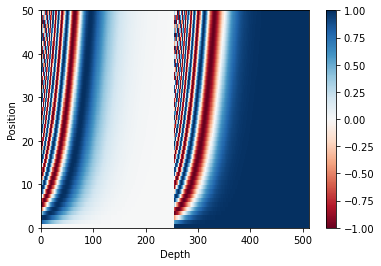

In [3]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

임베딩 벡터의 차원이 256이고 최대 문장의 길이가 30

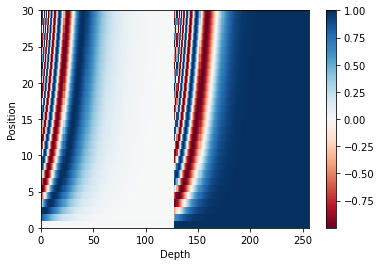

In [4]:
sample_pos_encoding = PositionalEncoding(30, 256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 256))
plt.ylabel('Position')
plt.colorbar()
plt.show()

실제 논문에서의 포지셔널 인코딩
![image-3.png](10.png)

# 어텐션
![image-3.png](11.png)

Query와 Key와의 유사도를 구하고, Key와 매핑되어 있는 Value에 반영

유사도가 반영된 Value를 모두 더해주면 **Attention Value(어탠션 값)**

## 트랜스포머에서 사용된 어텐션

![image-3.png](12.png)

- **Encoder self-attention**은 인코더에서 이루어짐
- **Masked Deccoder Self-Attention**은 디코더에서 이루어짐
- **Encoder-Decoder Atteion**도 디코더에서 이루어짐

![image-3.png](13.png)

Query, Key, Value는 기본적으로 '단어 (정보를 함축한) 벡터'

'단어 벡터'란 초기 입력으로 사용되었던 임베딩 벡터가 아니고, 트랜스포머의 여러 연산을 

거친 후의 '단어 벡터'

- 인코더 셀프 어텐션 : 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구한다.
- 디코더 셀프 어텐션 : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.
- 인코더-디코더 어텐션 : 디코더가 잘! 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.

## Self Attention

**셀프 어텐션**은 유사도를 구하는 대상이 다른 문장이 아닌 현재 문장의 단어들

Ex) Encoder - Decoder 어텐션은 (인코더 단어 , 디코더 단어) 셀프 어텐션이 아님

![image-3.png](14.png)

https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html

위의 문장 : '그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤하였기 때문이다.' 

여기서 it는 Street? or animal? 기계는 쉽게 알아내기 어렵다!

따라서 셀프 어텐션이 이를 잘 찾아내게 한다 -> 유사도를 구하는 방법은?

$$Attention(Q,K,V) = softmax \left( \frac {QK^T} {\sqrt{d_k}} \right) V$$

Q, K ,V 는 쿼리 키 밸류

어텐션 함수의 정의 : 
1. 쿼리에 대해서 모든 키와의 유사도를 구한다.
2. 이 유사도를 키와 맵핑되어 있는 값에 반영해준다.
3. 유사도가 반영된 Value를 더해서 뭉쳐주면 Attention value가 된다.

---

1. Q, K, V는 단어 벡터를 행으로 하는 문장 행렬임
2. 벡터의 내적(dot product)은 벡터의 유사도를 의미
3. 특정값을 분모로 사용하는 것은 크기 조절하는 Scaling을 위함

Q 와 K의 전치 행렬을 곱하는 것?
![image-3.png](15.png)

'am' 행과 'student'열의 값은 Q 행렬에 있던 'am' 벡터와 K 행렬에 있던 

'student' 벅테의 내적값을 의미. 이는 각 단어 벡터의 유사도가 모두 기록된 

유사도 행렬이 됨

---
이러한 유사도 값을 스케일링 해주기 위해서 행렬 전체를 특정값으로 나눠줌.
0~1 사이로 Normalize 해주기 위해 softmax 함수를 사용

그 이후에 문장행렬 V를 곱해주게 되면 Attention Value를 얻게 되는 것

![image-3.png](17.png)

$$Attention(Q,K,V) = softmax \left( \frac {QK^T} {\sqrt{d_k}} \right) V$$

이는 내적을 통해 유사도를 구하고 , 특정값을 분모로 나눠주는 방식으로 Q와 K의 

유사도를 구하였다고 하여, **스케일드 닷 프로덕트 어텐션(Scaled Dot-Projuct Attention)**

분모에 특정값을 나누지 않았다면? **닷 프로덕트 어텐션(dot product attention)**

## 구현

In [5]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  """어텐션 가중치를 계산. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

## 병렬로 어텐션 수행하기

![image-3.png](18.png)

위의 포지셔널 인코딩의 dmodel

## 멀티 헤드 어텐션의 효과

![image-3.png](19.png)

각각의 어텐션은 단어간의 관계들을 다른 관점으로 해석하기 때문에 여러 정보를 다양하게 활용 할 수 있음 이를 **멀티 헤드 어텐션** 이라함

## 멀티헤드 어텐션 구현

In [6]:
# 내부적으로는 스케일드 닷 프로덕트 어테션 함수를 호출합니다.
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다.
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷-프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

## Masking

특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법

## 패딩 마스킹(Padding Masking)
1. Padding token을 이용한 방법
![image-3.png](20.png)

패딩이란 문장의 길이를 맞춰주는 것 없는곳에 0 추가 위 그림은 `kears`의 `pad_sequences()` 사용하여 패딩함 0은 실제로 쓸모 없으므로 마스킹으로 지워줌

In [7]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [8]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


## 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)

트랜스포머는 전체 문장을 다 받기때문에 내 뒤의 문장을 알고 있으면 안좋음
이러한 문제를 해결하기 위해 룩 어헤드 마스킹 기법
![image-3.png](21.png)

In [9]:
# 위의 빨간 부분이 마스킹 부분이고 이를 구현하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [10]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


숫자 0인 단어가 있다면 이 또한 패딩해야 하므로 , 

앞서 구현한 패딩 마스크 함수도 호출하고 있다.

In [11]:
# 숫자 0이 포함되었을 경우
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


## 인코더

![image-3.png](22.png)

https://nlpinkorean.github.io/illustrated-transformer/

